# Projet OPA

## Partie 3 : Consomation des Données

In [1]:
from Binance.Data import Binance_Histo as Histo
from Binance.Data import Binance_Live as live
from Binance.Dao import Drivers_MongoDB as DAO_MB
from Binance.Dao import Drivers_SQlite as DAO_SQL

import pandas as pd
%matplotlib inline
import matplotlib.pyplot as plt

#### Step 1 : Connection à la base SQLite

In [2]:
PathDatabase = '/home/arnold/ENV_VIRTUEL/ATU_FORMATION/REP_DEV/Projet_OPA/DataBase/SQLite/test.db'
SQL = DAO_SQL.Drivers_SQLite(PathDatabase)

In [3]:
# Création DataFrame des Données Test / Entrainement
def CreateDataFrame(SQLScript, limite = -1) :
    
    res = SQL.Select(SQLScript, (limite,))

    L = list()
    for i in res:
        (a, b, c, d, e, f, g, h, i, j, l, m, n) = i
        L.append({'id_temps' : a, 'cours' : b, 
                 'DEC_ACHAT' : c, 'DEC_VENTE' : d ,
                 'IND_SMA_20' :e ,
                 'IND_SMA_30' :f ,
                 'IND_QUOTEVOLUME' : g ,
                 'IND_CHANGEPERCENT' :h,
                 'IND_STOCH_RSI' : i,
                 'IND_RSI' : j,
                 'IND_TRIX' : l,
                 'TOP_ACHAT' : m,
                 'TOP_VENTE' : n})

    return pd.DataFrame(L)

# Affichage des Données ( Valeurs Cours, ainsi que les décisions d'achat / vente )
def AffichageGraphe(df, limite = 300):
    
    df_temps = df.iloc[:limite]
    
    plt.figure(figsize= (10,10))
    plt.plot(df_temps.id_temps, df_temps.cours, label = 'Valeurs Cours')
    plt.scatter(df_temps[df_temps['DEC_ACHAT'] != 0].id_temps, df_temps[df_temps['DEC_ACHAT'] != 0].DEC_ACHAT ,linewidths= 5,c ='r', marker='^', label = 'Decison Achat')
    plt.scatter(df_temps[df_temps['DEC_VENTE'] != 0].id_temps, df_temps[df_temps['DEC_VENTE'] != 0].DEC_VENTE,linewidths= 5, c ='y', marker='v', label = 'Decison Vente')

    plt.legend()


#### Step 2 : Création Jeux Données Entrainement ML

In [4]:
sqlscript_Train ="""select datetime(A.id_temps/1000,'unixepoch'), 
    VALEUR_COURS, 
    VALEUR_COURS * B_A.IND_DEC, 
    VALEUR_COURS * B_V.IND_DEC,
    IND_SMA_20,
    IND_SMA_30,
    IND_QUOTEVOLUME,
    IND_CHANGEPERCENT,
    IND_STOCH_RSI,
    IND_RSI,
    IND_TRIX,
    B_A.IND_DEC, 
    B_V.IND_DEC
    from FAIT_SIT_COURS_HIST A
    inner join FAIT_DEC_ML_CLASS B_A ON (B_A.ID_SIT_CRS_HIS = A.ID_SIT_CRS_HIS and B_A.ID_MLCLAS = 3)
    inner join FAIT_DEC_ML_CLASS B_V ON (B_V.ID_SIT_CRS_HIS = A.ID_SIT_CRS_HIS and B_V.ID_MLCLAS = 4)
    inner join DIM_TEMPS C ON (C.ID_TEMPS = A.ID_TEMPS)
    where IND_SMA_30 is not null and C.ANNEE in ('2020')
    limit ?;"""


In [5]:
# Création du DataFrame Entrainement
df = CreateDataFrame(sqlscript_Train)

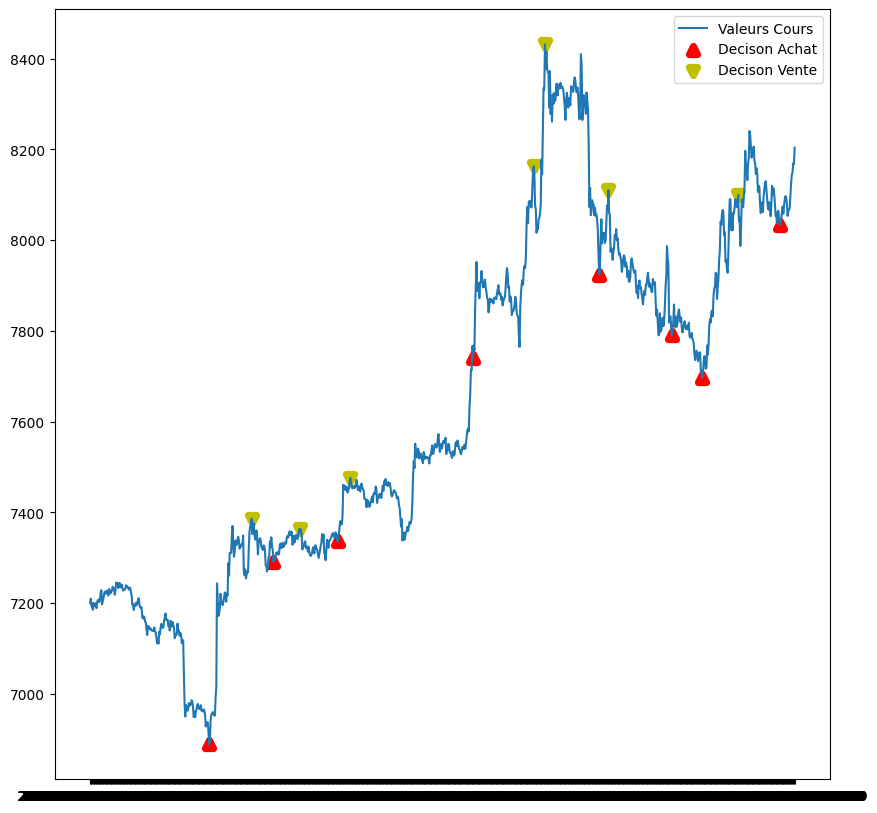

In [6]:
#Affichage Graphe des 1000 premiers Cours ainsi que les decisisions d'Achat
AffichageGraphe(df,1000)

#### Step 3 : Création du modéle ML avec l'algo Classification

In [7]:
from sklearn.linear_model import SGDClassifier
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import MinMaxScaler
from sklearn.tree import DecisionTreeClassifier

scaler = MinMaxScaler()

df_achat = df.drop(columns = ['id_temps','TOP_VENTE', 'DEC_ACHAT','DEC_VENTE', 'cours','IND_SMA_20', 'IND_SMA_30', 'IND_QUOTEVOLUME', 'IND_CHANGEPERCENT'])
df_vente = df.drop(columns = ['id_temps','TOP_ACHAT', 'DEC_ACHAT','DEC_VENTE', 'cours','IND_SMA_20', 'IND_SMA_30', 'IND_QUOTEVOLUME', 'IND_CHANGEPERCENT'])


##### Step 3.1 : Calcul Classification Achat

In [8]:

X = df_achat.drop(columns = ['TOP_ACHAT'])
y = df_achat['TOP_ACHAT']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 42)

"""
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)
X_train = pd.DataFrame(X_train, columns = X.columns)
X_test = pd.DataFrame(X_test , columns = X.columns)
"""

#MlClass_A = LogisticRegression(random_state = 42) 
#MlClass_A = SGDClassifier(max_iter=1000)

MlClass_A = DecisionTreeClassifier(random_state=42)
MlClass_A.fit(X_train, y_train)

print(MlClass_A.score(X_train, y_train))
print(MlClass_A.score(X_test, y_test))

print(X.columns)


1.0
0.9842902027992002
Index(['IND_STOCH_RSI', 'IND_RSI', 'IND_TRIX'], dtype='object')


##### Step 3.2 : Calcul Classification Vente

In [9]:

X = df_vente.drop(columns = ['TOP_VENTE'])
y = df_vente['TOP_VENTE']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 42)

"""
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)
X_train = pd.DataFrame(X_train, columns = X.columns)
X_test = pd.DataFrame(X_test , columns = X.columns)
"""

#MlClass_V = LogisticRegression(random_state = 42)
#MlClass_V = SGDClassifier(max_iter=1000)
MlClass_V = DecisionTreeClassifier(random_state=42)
MlClass_V.fit(X_train, y_train)

print(MlClass_V.score(X_train, y_train))
print(MlClass_V.score(X_test, y_test))

#print(X.columns)

1.0
0.9852899171665238


#### Step 4 : Prédiction Model sur un Jeu Réel

##### Step 4.1 : Résulat Prédiction

In [10]:
sqlscript_Test = """select datetime(A.id_temps/1000,'unixepoch'), 
    VALEUR_COURS, 
    VALEUR_COURS * B_A.IND_DEC, 
    VALEUR_COURS * B_V.IND_DEC,
    IND_SMA_20,
    IND_SMA_30,
    IND_QUOTEVOLUME,
    IND_CHANGEPERCENT,
    IND_STOCH_RSI,
    IND_RSI,
    IND_TRIX,
    B_A.IND_DEC, 
    B_V.IND_DEC
    from FAIT_SIT_COURS_HIST A
    inner join FAIT_DEC_ML_CLASS B_A ON (B_A.ID_SIT_CRS_HIS = A.ID_SIT_CRS_HIS and B_A.ID_MLCLAS = 3)
    inner join FAIT_DEC_ML_CLASS B_V ON (B_V.ID_SIT_CRS_HIS = A.ID_SIT_CRS_HIS and B_V.ID_MLCLAS = 4)
    inner join DIM_TEMPS C ON (C.ID_TEMPS = A.ID_TEMPS)
    where IND_SMA_30 is not null and C.ANNEE = '2021'
    limit ?; """


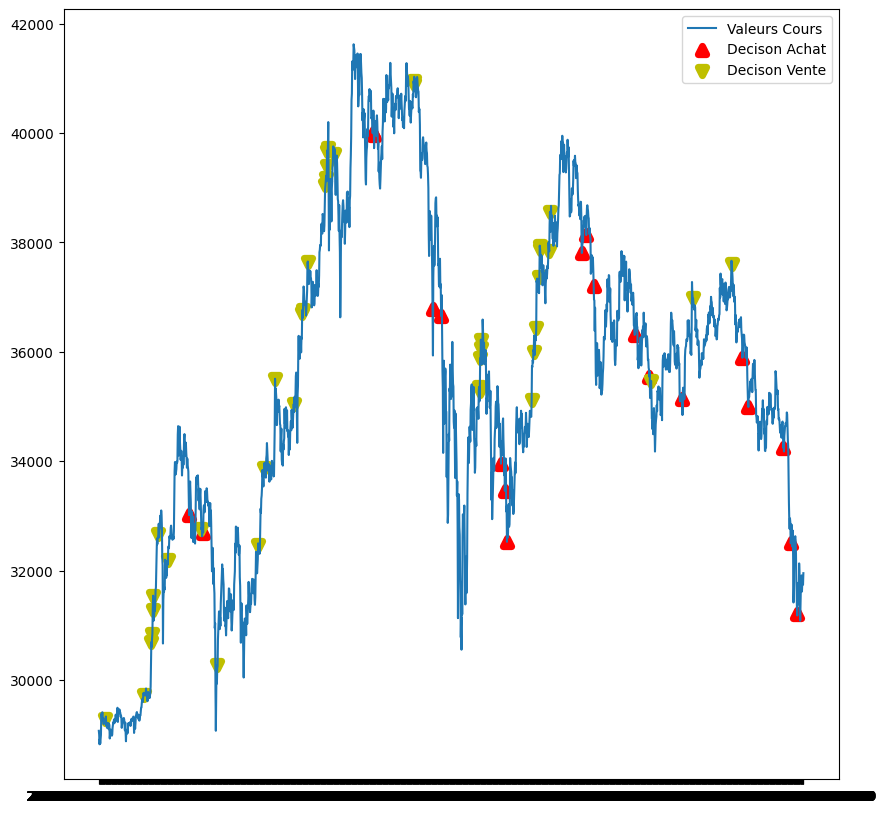

In [11]:
df_test = CreateDataFrame(sqlscript_Test).drop(columns = ['TOP_ACHAT','TOP_VENTE','DEC_ACHAT','DEC_VENTE','IND_SMA_20', 'IND_SMA_30', 'IND_QUOTEVOLUME', 'IND_CHANGEPERCENT'])

y_pred_V = MlClass_V.predict(df_test.drop(columns = ['id_temps', 'cours']))
y_pred_A = MlClass_A.predict(df_test.drop(columns = ['id_temps', 'cours']))

df_test = pd.concat([df_test, pd.DataFrame(y_pred_V, columns = ['TOP_VENTE']), pd.DataFrame(y_pred_A, columns = ['TOP_ACHAT'])], axis = 1 )
df_test['DEC_ACHAT'] = df_test['cours'] * df_test['TOP_ACHAT']
df_test['DEC_VENTE'] = df_test['cours'] * df_test['TOP_VENTE']

# Prévision sur les 2000 premiers cours
AffichageGraphe(df_test, 2000)

##### Step 4.2 : Résulat attendu

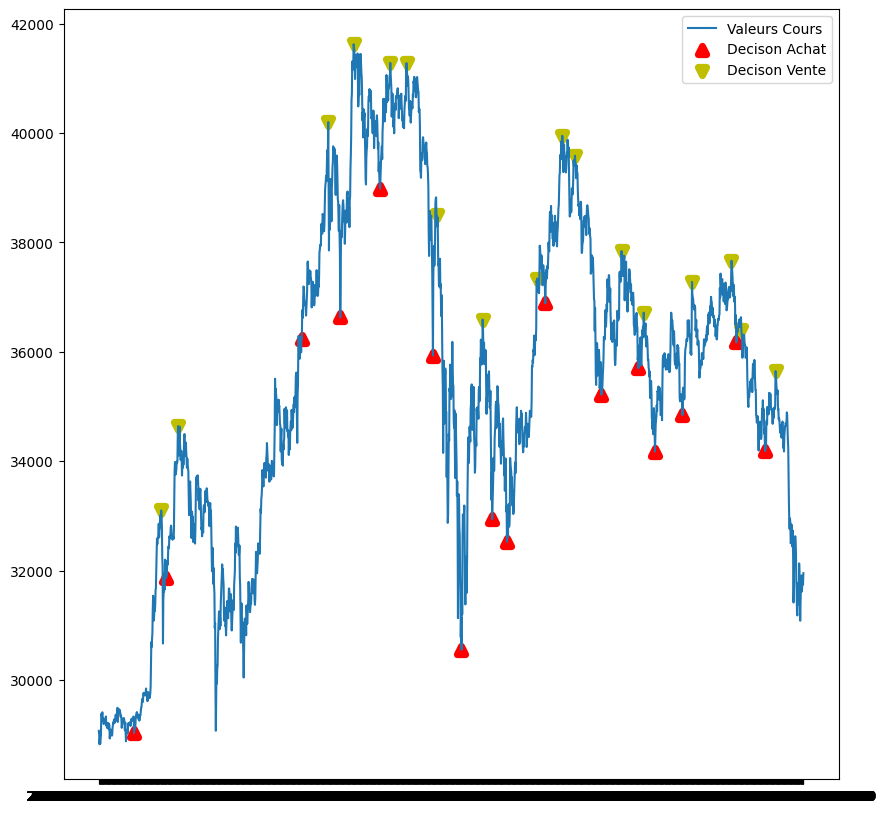

In [12]:
# Prévision Rélle attendue sur les 2000 premiers cours
df_reel = CreateDataFrame(sqlscript_Test)
AffichageGraphe(df_reel,2000)